<span style="font-size:24px; font-weight:bold;">A tutorial for Stochastic Variational Inference Gaussian Process  </span>


Author: Zidong Chen

Date: 2024/07/16

Reference: [Gaussian process for big data](https://arxiv.org/pdf/1309.6835)

In [269]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import os
from core.kernel import ARDKernel
import torch.optim as optim
import core.GP_CommonCalculation as GP
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-4 
EPS = 1e-10
PI = 3.1415
torch.set_default_dtype(torch.float64)

In [270]:
# Train set
num_data = 100  # We initialize 10 thousands training data to see its scalability

xtr = torch.rand(num_data, 1, dtype=torch.float64)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(num_data, 1, dtype=torch.float64) * 0.1

# Test set
xte = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)

You must normalize the training data to use this method. The mean of the inducing points are learnable and initialized as zero. If there is a large difference between the real mean and zero, it may cause the mean to fail to update.


In [271]:
# normalize
normalizer=GP.DataNormalization(method='standard',mode=0)
normalizer.fit(xtr,'xtr')
normalizer.fit(ytr,'ytr')
x_normalized=normalizer.normalize(xtr,'xtr')
y_normalized=normalizer.normalize(ytr,'ytr')
xte_normalized=normalizer.normalize(xte,'xtr')

In [272]:
#subset_set_of_training_set
num_inducing=10
xm=nn.Parameter(torch.rand(num_inducing,1))
q_u_mean=nn.Parameter(torch.zeros(xm.size(0),1))
chole=nn.Parameter(torch.rand(xm.size(0),1)) # this is trained instead of the covariance to ensure positive definite

In [273]:
log_beta = nn.Parameter(torch.ones(1)*0)

In [274]:
kernel=ARDKernel(1)

The lowerbound introduced by Hensman et al. [2013]
$$
\mathcal{L} = \mathbb{E}_{q(\mathbf{f}, \mathbf{u})}[\log p(\mathbf{y}|\mathbf{f})] - \mathrm{KL}[q(\mathbf{u})||p(\mathbf{u})]
$$
allow us to apply mini-batch learning on sparse GP

$$
\mathcal{L} = \sum_{i=1}^{n} \left\{ \log \mathcal{N}\left(y_i \middle| k_i^T K_{mm}^{-1} m, \beta^{-1}\right) - \frac{1}{2} \beta k_{i,i} - \frac{1}{2} \text{tr}(S \Lambda_i) \right\} - \mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})]
$$
$$
\mathcal{L} = \sum_{i=1}^{n} \left\{-\frac{1}{2} \log(2 \pi \beta^{-1}) - \frac{\beta}{2} \left((y_i - k_i^T K_{mm}^{-1} m)^2 \right)- \frac{1}{2} \beta k_{i,i} - \frac{1}{2} \text{tr}(S \Lambda_i) \right\} - \mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})]
$$
And:
$$
\mathrm{KL}[q(\mathbf{u}) \parallel p(\mathbf{u})] = \frac{1}{2} \left( \text{tr}(\mathbf{K_{mm}}^{-1}\mathbf{S}) + \mathbf{m}^T \mathbf{K_{mm}}^{-1} \mathbf{m} - \log\left(\frac{|\mathbf{S}|}{|\mathbf{K_{mm}}|}\right) - d \right)
$$
[reference for KL](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

Where $\tilde{k}_{i,i}$ is the ith diagonal element of $\tilde{\mathbf{K}}$

$$
\tilde{\mathbf{K}} = \mathbf{K}_{nn} - \mathbf{K}_{nm} \mathbf{K}_{mm}^{-1} \mathbf{K}_{mn}
$$
$\mathbf{k}_i$ is a vector representing the $i$-th column of $\mathbf{K}_{mn}$

and $\Lambda_i$is defined as:

$$\Lambda_i = \beta \mathbf{K}_{mm}^{-1} \mathbf{k}_i \mathbf{k}_i^\top \mathbf{K}_{mm}^{-1} $$

As we can see, this lower bound is disjoint for each training data point, allowing us to implement mini-batch gradient descent during training. Below is the implementation without mini-batch; more details on how to perform mini-batch gradient descent can be found in core.svgp.py


In [275]:
def negative_lower_bound(q_u_mean,chole,xm,xtr,ytr,kernel,log_beta):
    b=xtr.size(0) #batch size

    k_mm=kernel(xm, xm)+JITTER * torch.eye(xm.size(0))
    k_mn=kernel(xm, xtr)
    Lm = torch.linalg.cholesky(k_mm)
    k_nm=k_mn.t()

    gamma,_ = torch.triangular_solve(k_mn, Lm, upper = False)
    K=gamma.t()@gamma
    K_tilda=(kernel(xtr, xtr).diag()-K.diag()).view(-1,1)

    #Option 1
    #k_mm_inv=torch.inverse(k_mm)

    #Option 2 More efficient and stable
    k_mm_inv= torch.cholesky_inverse(Lm)

    q_u_S=chole@chole.t()+JITTER * torch.eye(xm.size(0))
    Ls=torch.linalg.cholesky(q_u_S)
    #Ls=flat_to_trian(chole)
    #q_u_S=Ls@Ls.t()


    A_i=log_beta.exp()*(k_mm_inv@k_mn@k_nm@k_mm_inv)
    SA_i=q_u_S@A_i
    tr_SA_i=SA_i.diag()
    L=-0.5*b*torch.log(2*torch.tensor(PI))+0.5*b*torch.log(log_beta.exp())\
      -0.5*log_beta.exp()*((ytr-k_nm@k_mm_inv@q_u_mean)**2).sum(dim = 0).view(-1,1)\
      -0.5*log_beta.exp()*K_tilda.sum(dim = 0).view(-1,1)-0.5*(tr_SA_i.sum(dim = 0).view(-1,1))


    # compute KL
    logdetS = 2 * Ls.diag().log().sum()
    logdetKmm=2*Lm.diag().log().sum()
    k_mm_invS=k_mm_inv@q_u_S

    KL =  0.5*k_mm_invS.diag().sum(dim = 0).view(-1,1)+ 0.5*(q_u_mean.t()@k_mm_inv@q_u_mean)-0.5*logdetS+ 0.5*logdetKmm -0.5*num_inducing

    return KL,L,k_mm_inv

In [276]:
num_epochs = 500
optimizer = optim.Adam([q_u_mean, chole, log_beta,xm] + list(kernel.parameters()), lr=0.1) #You probably need a large learning rate to escape local minima

for i in range(num_epochs):
    optimizer.zero_grad()
    KL,L,k_mm_inv=negative_lower_bound(q_u_mean,chole,xm,x_normalized,y_normalized,kernel,log_beta)
    loss=KL-L
    loss.backward()
    optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
    if i % 10 == 0:

        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:4520.01152
iter 10 nll:478.84124
iter 20 nll:233.59101
iter 30 nll:199.93108
iter 40 nll:186.72108
iter 50 nll:181.45472
iter 60 nll:178.75020
iter 70 nll:176.10459
iter 80 nll:173.61532
iter 90 nll:171.23887
iter 100 nll:168.77413
iter 110 nll:166.26735
iter 120 nll:163.68479
iter 130 nll:161.02301
iter 140 nll:158.27282
iter 150 nll:155.42140
iter 160 nll:152.45076
iter 170 nll:149.33229
iter 180 nll:146.02326
iter 190 nll:142.46444
iter 200 nll:138.57992
iter 210 nll:134.27647
iter 220 nll:129.44144
iter 230 nll:123.94636
iter 240 nll:117.67881
iter 250 nll:110.63972
iter 260 nll:113.58400
iter 270 nll:114.11807
iter 280 nll:105.00071
iter 290 nll:94.89447
iter 300 nll:84.17556
iter 310 nll:74.36554
iter 320 nll:64.24907
iter 330 nll:53.33813
iter 340 nll:41.68981
iter 350 nll:29.37199
iter 360 nll:16.46692
iter 370 nll:3.04940
iter 380 nll:-10.56028
iter 390 nll:-24.17161
iter 400 nll:-37.68769
iter 410 nll:-51.03660
iter 420 nll:-64.02143
iter 430 nll:305.26029
iter 440

In [277]:
_,_,k_mm_inv=negative_lower_bound(q_u_mean,chole,xm,x_normalized,y_normalized,kernel,log_beta)
def forward(xm,xte,q_u_mean,kernel, chole,log_beta):
    K_tt=kernel(xte,xte)
    K_tm=kernel(xte,xm)
    K_mt= K_tm.t()
    ypred=(K_tm@k_mm_inv)@q_u_mean
    yvar=K_tt-K_tm@k_mm_inv@K_mt+K_tm@k_mm_inv@(chole @ chole.t())@k_mm_inv@K_mt
    yvar = yvar.diag().view(-1,1)
    return ypred,yvar

<ErrorbarContainer object of 3 artists>

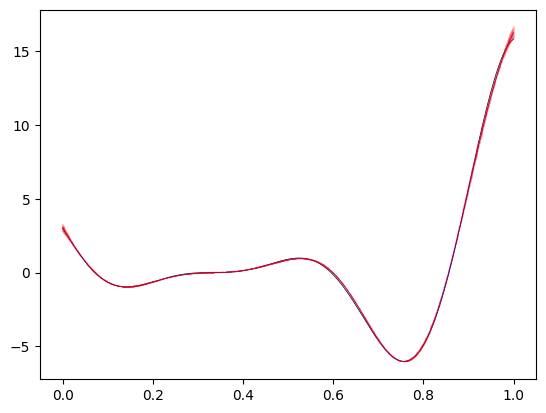

In [278]:
ypred,yvar=forward(xm,xte_normalized,q_u_mean,kernel,chole, log_beta)
ypred=normalizer.denormalize(ypred,'ytr')
yvar=normalizer.denormalize_cov(yvar,'ytr')
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.detach().numpy(), label='Prediction', c='b',lw=0.5)
plt.errorbar(xte.numpy().reshape(1000), ypred.detach().numpy().reshape(1000),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)